# Putting it all together
## Coupling dynamic soil and hydraulic plant architecture models
In this Jupyter Notebook, we compine plant hydraulic architecture models with dynamic soil models. 
In the first part, we couple the plant hydraulic architecture with a dynamic soil grid at the macroscale. 
In the second part, we add individual perirhizal zone models around the single root segments. 


### Coupling plant hydraulic architecture to a macroscopic soil grid
Spatial coupling of the soil and the root hydraulic architecture is done in the *Mapped-Plant class* for general soil grids. *Mapped plant* is a specialisation of the *Plant class*, which keeps track of emerging new nodes and segments and their location inside the numerical soil grid. Therefore, the *MappedPlant class* needs a function that maps each point in space to a linear index (representing a grid cell used by the numeric solver). Temporal coupling as achieved  by solving each of the modules, plant and soil, sequentially, within each time step as described in Giraud et al. (2025).  

The following example simulates root water uptake by a growing root system from a drying soil. 

First, we import all the necessary libraries and set paths to the required directories of CPlantBox and DuMux-Rosi. 


In [2]:
import os
sourcedir = os.getcwd()+"/../../.."
filedir = os.getcwd()
os.chdir(filedir)

In [3]:
""" Adding the paths for CPlantBox and DuMux as solver for the soil part """
import sys; sys.path.append(sourcedir); sys.path.append(sourcedir+"/src")
sys.path.append("../../../../dumux-rosi/build-cmake/cpp/python_binding/")
sys.path.append("../../../../dumux-rosi/python/modules/")
sys.path.append("../../../../dumux-rosi/python/modules/fv/")

In [4]:
import plantbox as pb
import visualisation.vtk_plot as vp
from functional.xylem_flux import XylemFluxPython  # Python hybrid solver
from functional.root_conductivities import *  # hard coded conductivities
from rosi_richards import RichardsSP  # C++ part (Dumux binding)
from richards import RichardsWrapper  # Python part

import numpy as np
import matplotlib.pyplot as plt
import timeit

Next, we set all the necessary parameters for both the soil and the plant models, as well as numerical parameters, and initialise the models. Furthermore, we define points at which the results for the dynamic variables will be stored, in this case the soil cell in which the root collar is located. 

In [5]:
def sinusoidal(t):
    return np.sin(2. * np.pi * np.array(t) - 0.5 * np.pi) + 1.


""" Parameters """
min_b = [-4., -4., -25.]
max_b = [4., 4., 0.]
cell_number = [8, 8, 25]  # [16, 16, 30]  # [32, 32, 60]
periodic = False

path = "../../../modelparameter/structural/rootsystem/"
name = "Anagallis_femina_Leitner_2010" 
loam = [0.08, 0.43, 0.04, 1.6, 50]
initial = -659.8 + 12.5  # -659.8

trans = 6.4  # cm3 /day (sinusoidal)
wilting_point = -10000  # cm

sim_time = 7  # [day] 
rs_age = 10  # root system initial age
age_dependent = False  # conductivities
dt = 360. / (24 * 3600)  # [days] Time step must be very small


""" Initialize macroscopic soil model """
s = RichardsWrapper(RichardsSP())
s.initialize()
s.createGrid(min_b, max_b, cell_number, periodic)  # [cm]
s.setHomogeneousIC(initial, True)  # cm pressure head, equilibrium
s.setTopBC("noFlux")
s.setBotBC("noFlux")
s.setVGParameters([loam])
s.initializeProblem()
s.setCriticalPressure(wilting_point)

""" Initialize xylem model """
rs = pb.MappedPlant()
rs.readParameters(path + name + ".xml")
if not periodic:
    sdf = pb.SDF_PlantBox(0.99 * (max_b[0] - min_b[0]), 0.99 * (max_b[1] - min_b[1]), max_b[2] - min_b[2])
else:
    sdf = pb.SDF_PlantBox(np.Inf, np.Inf, max_b[2] - min_b[2])
rs.setGeometry(sdf)
r = XylemFluxPython(rs)
init_conductivities(r, age_dependent)

""" Coupling (map indices) """
picker = lambda x, y, z: s.pick([x, y, z])
r.rs.setSoilGrid(picker)  # maps segments
r.rs.setRectangularGrid(pb.Vector3d(min_b), pb.Vector3d(max_b), pb.Vector3d(cell_number), True)
rs.initialize()
rs.simulate(rs_age, False)
r.test()  # sanity checks
nodes = r.get_nodes()
cci = picker(nodes[0, 0], nodes[0, 1], nodes[0, 2])  # collar cell index

No parameter file found. Continuing without parameter file.
createGrid False
Computed bounding box tree with 3199 nodes for 1600 grid entities in 0.000656889 seconds.
Computed bounding box tree with 3199 nodes for 1600 grid entities in 0.000464211 seconds.
RichardsProblem constructed: bcTopType 2, 0; bcBotType 2, 0,  Output File 0, Critical pressure -10000 gravity 1

Newton solver configured with the following options and parameters:
 -- Newton.EnableShiftCriterion = true (relative shift convergence criterion)
 -- Newton.MaxRelativeShift = 1e-08
 -- Newton.MinSteps = 2
 -- Newton.MaxSteps = 18
 -- Newton.TargetSteps = 10
 -- Newton.RetryTimeStepReductionFactor = 0.5
 -- Newton.MaxTimeStepDivisions = 10


Newton solver configured with the following options and parameters:
 -- Newton.EnableShiftCriterion = true (relative shift convergence criterion)
 -- Newton.MaxRelativeShift = 1e-08
 -- Newton.MinSteps = 2
 -- Newton.MaxSteps = 18
 -- Newton.TargetSteps = 10
 -- Newton.RetryTimeStepRed

In the main simulation loop, we sequentially perform (a) plant growth, (b) compute xylem pressure potential and (c) calculate the fluxes from soil grid cells into the plant roots as well as the soil matric potentials. The resulting actual transpiration at each time step is stored. Two figurs are produced, one that shows the soil matric potentials in the 3D soil domain as well as the root architecture and xylem pressure potentials, and a 2D plot that shows the actual, potential and cumulative transpiration with respect to time.  

 -- Using the default temperature of 293.15 in the entire domain. Overload temperatureAtPos() in your spatial params class to define a custom temperature field.Or provide the preferred domain temperature via the SpatialParams.Temperature parameter.
[                                                                                                    ], [-659.3, -635.3] cm soil [-656.795, -637.312] cm root at 0.00416667 days -656.795
[                                                                                                    ], [-659.3, -635.3] cm soil [-657.326, -637.484] cm root at 0.00833333 days -657.326
[                                                                                                    ], [-659.3, -635.3] cm soil [-658.917, -638.009] cm root at 0.0125 days -658.917
[                                                                                                    ], [-659.3, -635.3] cm soil [-661.575, -638.893] cm root at 0.0166667 days -661.575
[           

/home/aschnepf/mambaforge/lib/python3.12/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


[************************************                                                                ], [-9221.57, -642.686] cm soil [-10000, -7380.25] cm root at 2.5 days -10000
[************************************                                                                ], [-9234.05, -642.738] cm soil [-10000, -7417.92] cm root at 2.50417 days -10000
[************************************                                                                ], [-9245.7, -642.791] cm soil [-10000, -7471.31] cm root at 2.50833 days -10000
[************************************                                                                ], [-9256.51, -642.843] cm soil [-10000, -7521.98] cm root at 2.5125 days -10000
[************************************                                                                ], [-9266.44, -642.896] cm soil [-10000, -7563.64] cm root at 2.51667 days -10000
[************************************                                                      

2025-07-23 16:05:20.399 ( 181.504s) [        3F992740]       vtkXMLWriter.cxx:649    ERR| vtkXMLPolyDataWriter (0x5595c2ceb990): Error opening output file "results/Anagallis_femina_Leitner_2010.vtp"
2025-07-23 16:05:20.399 ( 181.504s) [        3F992740]       vtkXMLWriter.cxx:651    ERR| vtkXMLPolyDataWriter (0x5595c2ceb990): Error code "No such file or directory"
2025-07-23 16:05:20.399 ( 181.504s) [        3F992740]       vtkExecutive.cxx:740    ERR| vtkCompositeDataPipeline (0x5595beeced30): Algorithm vtkXMLPolyDataWriter (0x5595c2ceb990) returned failure for request: vtkInformation (0x5595c2368be0)
  Debug: Off
  Modified Time: 495075
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: -1
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2025-07-23 16:05:20.399 ( 181.505s) [        3F992740]       vtkXMLWriter.cxx:649    ERR| vtkXMLImageDataWriter (0x5595c269bf30): Error opening output file "results/Anagallis_femina_Leitner_2010.vtu"
202

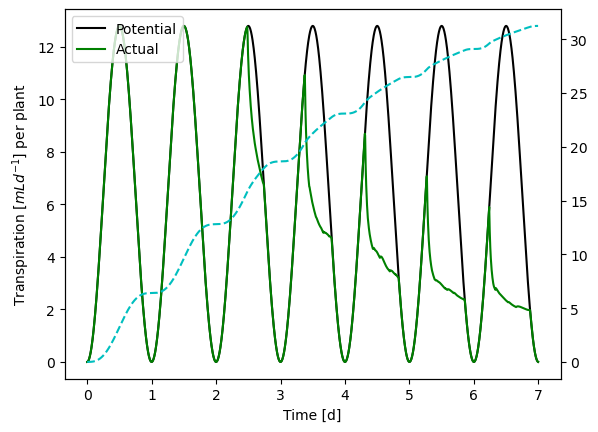

In [6]:
""" Numerical solution """
start_time = timeit.default_timer()
x_, y_ = [], []
sx = s.getSolutionHead()  # inital condition, solverbase.py
N = round(sim_time / dt)
t = 0.

for i in range(0, N):

    rs.simulate(dt)

    rx = r.solve(rs_age + t, -trans * sinusoidal(t), sx[cci], sx, True, wilting_point)  # xylem_flux.py
    x_.append(t)
    y_.append(float(r.collar_flux(rs_age + t, rx, sx)))  # exact root collar flux

    fluxes = r.soilFluxes(rs_age + t, rx, sx, False)
    s.setSource(fluxes)  # richards.py
    s.solve(dt)
    sx = s.getSolutionHead()  # richards.py

    min_sx, min_rx, max_sx, max_rx = np.min(sx), np.min(rx), np.max(sx), np.max(rx)
    n = round(float(i) / float(N) * 100.)
    print("[" + ''.join(["*"]) * n + ''.join([" "]) * (100 - n) + "], [{:g}, {:g}] cm soil [{:g}, {:g}] cm root at {:g} days {:g}"
            .format(min_sx, max_sx, min_rx, max_rx, s.simTime, rx[0]))
    t += dt

print ("Coupled benchmark solved in ", timeit.default_timer() - start_time, " s")

""" VTK visualisation """
vp.plot_roots_and_soil(r.rs, "pressure head", rx, s, periodic, np.array(min_b), np.array(max_b), cell_number, name)

""" transpiration over time """
fig, ax1 = plt.subplots()
ax1.plot(x_, trans * sinusoidal(x_), 'k')  # potential transpiration
ax1.plot(x_, -np.array(y_), 'g')  # actual transpiration (neumann)
ax2 = ax1.twinx()
ax2.plot(x_, np.cumsum(-np.array(y_) * dt), 'c--')  # cumulative transpiration (neumann)
ax1.set_xlabel("Time [d]")
ax1.set_ylabel("Transpiration $[mL d^{-1}]$ per plant")
ax1.legend(['Potential', 'Actual', 'Cumulative'], loc = 'upper left')
np.savetxt(name, np.vstack((x_, -np.array(y_))), delimiter = ';')
plt.show()
